# Label Propagation

Quick implementation of label propagation on a two moon dataset with comparisons to a support vector machine and k-nearest neighbours. More information found on my [blog post](https://ktmai.github.io/2019-12/label-propagation).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

We will generate a two moon dataset with some noise.

In [0]:
X, y = make_moons(noise=0.1)

Let's plot all of the points in the ideal situation where all points are known.

In [0]:
def plot_points(X, y, X_test = None, y_test = None):
  plt.figure(figsize=(10,10))
  colour = ['red' if label == 0 else 'blue' if label == 1 else 'gray' for label in y]
  plt.scatter(X[:,0], X[:,1], color=colour)
  if X_test is not None:
    colour = ['red' if label == 0 else 'blue' if label == 1 else 'gray' for label in y_test]
    plt.scatter(X_test[:,0], X_test[:,1], color = colour, marker='+')
  plt.show()

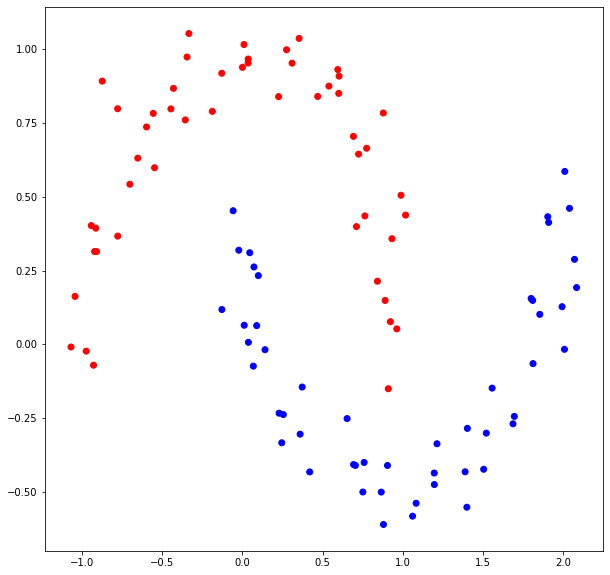

In [4]:
# Visualise the points
plot_points(X,y)

Let's create a semi-supervised setting by only assigning labels to two points. For visualisation purposes, we will set the remaining labels to -1.

In [0]:
# Create a new array of labels
y_prime = -1*np.ones(y.shape)

# Assign labels to the furtherst left and right samples
X_min = np.argmin(X, axis=0)[0]
X_max = np.argmax(X, axis=0)[0]

y_prime[X_min] = 0
y_prime[X_max] = 1

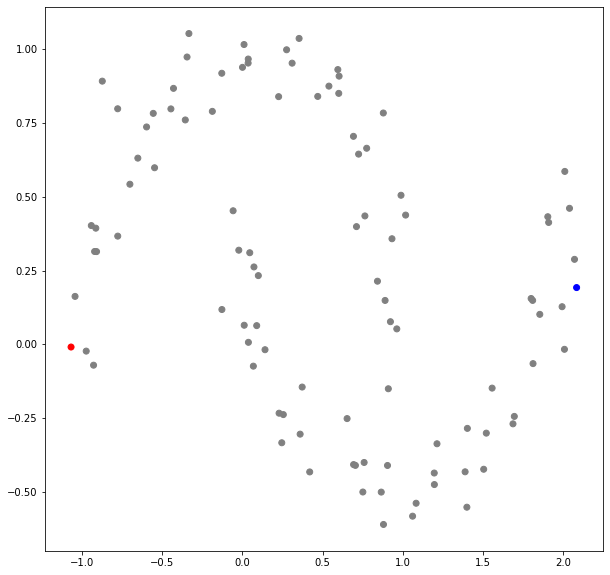

In [6]:
# Plot with this new semi-supervised setup
plot_points(X, y_prime)

# Comparison with local methods

We will perform learning using an SVM and k-NN, which are more local methods to compare with label propagation.

## SVM with RBF

We will use a support vector machine with a radial basis function ('RBF') kernel to account for the non linear data. Incidentially, this is the same kernel used to construct the weight matrix for the graph in the label propagation algorithm.

In [0]:
# Create the training and test data
X_train = np.vstack((X[X_min], X[X_max]))
y_train = np.array([0,1])

X_test = np.delete(X, (X_min, X_max), axis=0)

In [8]:
# Fit the SVM
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Get the predictions for the test data
svm_preds = svm_clf.predict(X_test)

The predictions of the SVM (shown with + markers) and the labelled training data are shown below. The SVM neglects the global two moon shape as it only has the two training points to construct the margin. Hence we can expect the decision boundary to cut vertically through the middle.

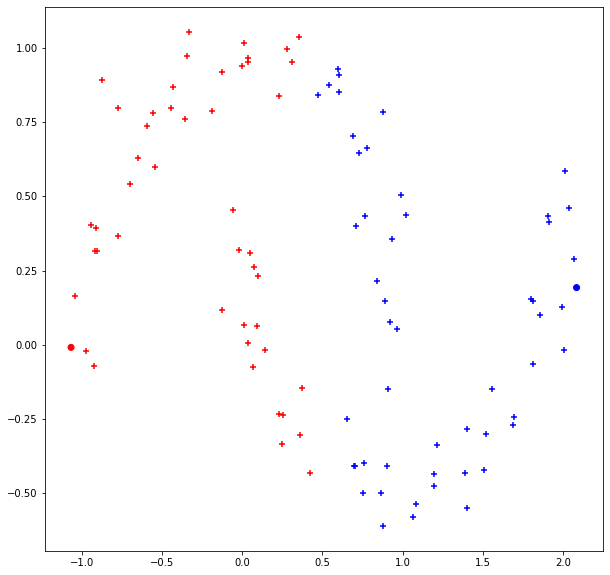

In [10]:
plot_points(X_train, y_train, X_test, svm_preds)

## k-NN

To emphasise the local nature of k-NN, we will set k to be 1. In other words, we will classify the points depending on its closest neighbour.

In [11]:
# Fit the 1-NN
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
# Obtain 1-NN predictions
knn_preds = knn_clf.predict(X_test)

With 1-NN we get a similar result to the SVM.

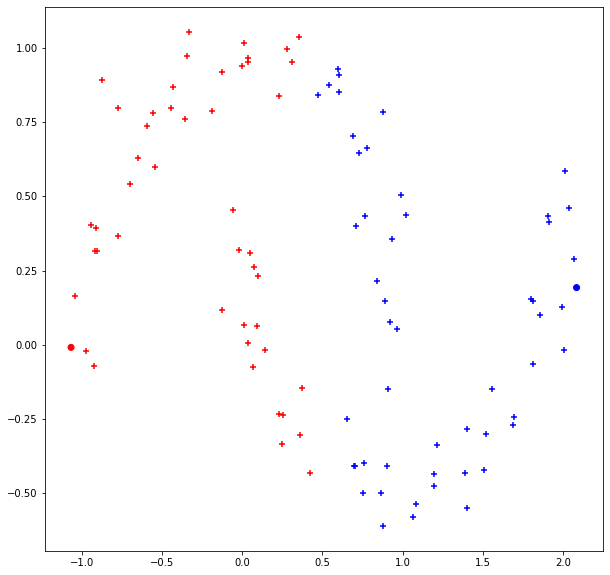

In [13]:
plot_points(X_train, y_train, X_test, knn_preds)

# Label Propagation Implementation

Let's start by creating the weight matrix. We will use the Gaussian kernel:

$$\textbf{W}_{ij} = e^{-\frac{\lvert\lvert x_i - x_j \rvert\rvert^2}{2 \sigma^2}}$$

Note $\sigma$ is a hyperparameter.

In [0]:
def gaussian_kernel(X, sigma):
  X2 = np.sum(X**2, axis=-1)
  return np.exp(-(0.5*sigma) * (X2[:, np.newaxis] + X2[np.newaxis,:] - 2*np.dot(X, X.T)))

In [0]:
W = gaussian_kernel(X, 40)

From the Gaussian kernel, let's calculate its summation.

In [0]:
D = np.sum(W, axis=0)

Using W and D, let's get the transition matrix:

In [0]:
T = W / D[:, np.newaxis]

Now let's create $\hat{Y}^{(0)}$. where it contains both $Y_{train}$ and $\hat{Y}^{(0)}_{test}$. As we have two classes $C \in \{0, 1\}$ and 100 data points, we need to make  $\hat{Y}^{(0)}$ a $100 \times 2$ vector. We can set the certainty of $Y_{train}$ to be $1$ with respect to their labels as they are known. The initialisation of $\hat{Y}^{(0)}_{test}$ is less important so we can set them to zeroes.

In [0]:
y_hat = np.zeros((len(X), 2))

# Add labels where the labelled data is located
y_hat[X_min,0] = 1
y_hat[X_max,1] = 1

# For ease of fitting, record where the labelled data is originally stored
where_labelled = (y_prime != -1)

Now let's define the training loop for label propagation. For this, we need to set a $\delta$ as a condition to stop training.

In [0]:
def lp_fit(T, y_hat, where_labelled, X_train, delta=1e-3, max_iter=1000):
  # Store the initial value f y_hat for clamping
  y_0 = y_hat
  # Initialise vector to hold previous values of y_hat
  y_prev = np.zeros((y_hat.shape))
  # Loop until condition is met
  while(np.sum(np.abs(y_hat - y_prev)) > delta or max_iter == 0):
    y_prev = y_hat
    # Conduct label propagation
    y_hat = np.dot(T, y_hat)
    # Normalise
    y_hat = y_hat / np.sum(y_hat, axis=1).reshape(-1,1)
    # Clamp the data. If labelled, replace with original values
    y_hat = np.where(where_labelled[:, np.newaxis], y_0, y_hat)
    max_iter -= 1
  # Convert back into hard labels
  result = np.argmax(y_hat, axis=1)
  return result

In [0]:
# Perform label propagation
fit_data = lp_fit(T, y_hat, where_labelled, X_train)

Let's get predictions for the test set by removing the training entries in the fit data.

In [0]:
lp_preds = np.delete(fit_data, (X_min, X_max), axis=0)

Finally, let's plot the results. As label propagation is transductive and takes into account the test data, we can see it recognises the two moon shape.

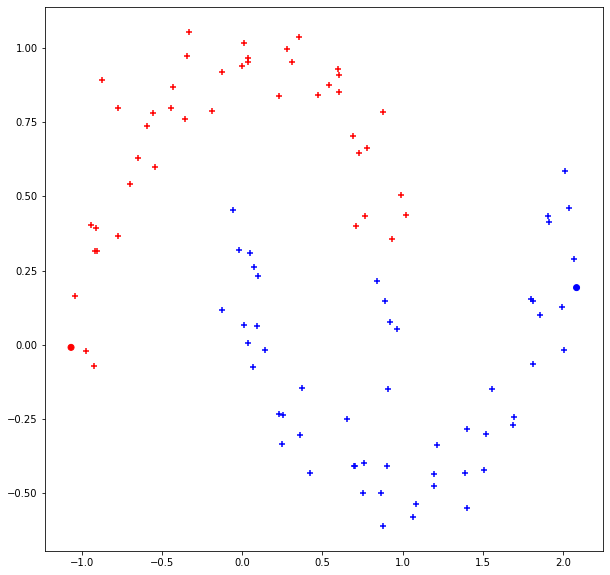

In [22]:
plot_points(X_train, y_train, X_test, lp_preds)